In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Обучающая выборка
original_train = pd.read_csv('movies.csv', sep=",")

In [3]:
# Удалим дубликаты записей, если они присутствуют
train = original_train.drop_duplicates()

# Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

## Основные характеристики датасетов

In [4]:
# Первые 5 строк датасета
train.head()

,Unnamed: 0,ID,Title,Year,Rating,IMDb,Rotten Tomatoes,Genre,Netflix,Amazon Prime Video
0,0,1,Terminator: Dark Fate,2019,18+,6.2,81,Action & Adventure,0,1
1,1,2,Gemini Man,2019,13+,5.7,74,Action & Adventure,0,1
2,2,3,Rambo: Last Blood,2019,18+,6.1,72,Action & Adventure,0,1
3,3,4,The Courier,2019,18+,4.9,50,Action & Adventure,0,1
4,4,5,Crawl,2019,18+,6.1,79,Action & Adventure,0,1


In [5]:
# Размер обучающего датасета - 1001 строка, 17 колонок
train.shape

(24664, 10)

In [6]:
# Список колонок
train.columns

Index(['Unnamed: 0', 'ID', 'Title', 'Year', 'Rating', 'IMDb',
       'Rotten Tomatoes', 'Genre', 'Netflix', 'Amazon Prime Video'],
      dtype='object')

In [7]:
# Список колонок с типами данных 
# убедимся что типы данных одинаковы в обучающей и тестовых выборках
train.dtypes

Unnamed: 0             int64
ID                     int64
Title                 object
Year                   int64
Rating                object
IMDb                  object
Rotten Tomatoes       object
Genre                 object
Netflix                int64
Amazon Prime Video     int64
dtype: object

In [8]:
# Проверим наличие пустых значений
train.isnull().sum()

Unnamed: 0                0
ID                        0
Title                     0
Year                      0
Rating                14635
IMDb                    420
Rotten Tomatoes           0
Genre                     0
Netflix                   0
Amazon Prime Video        0
dtype: int64

In [9]:
train=train.dropna()

In [10]:
train.shape

(9993, 10)

In [11]:
# Проверим наличие пустых значений
train.isnull().sum()

Unnamed: 0            0
ID                    0
Title                 0
Year                  0
Rating                0
IMDb                  0
Rotten Tomatoes       0
Genre                 0
Netflix               0
Amazon Prime Video    0
dtype: int64

Вывод. Представленный набор данных не содержит пропусков в обучающей выборке.

## Построение графиков для понимания структуры данных

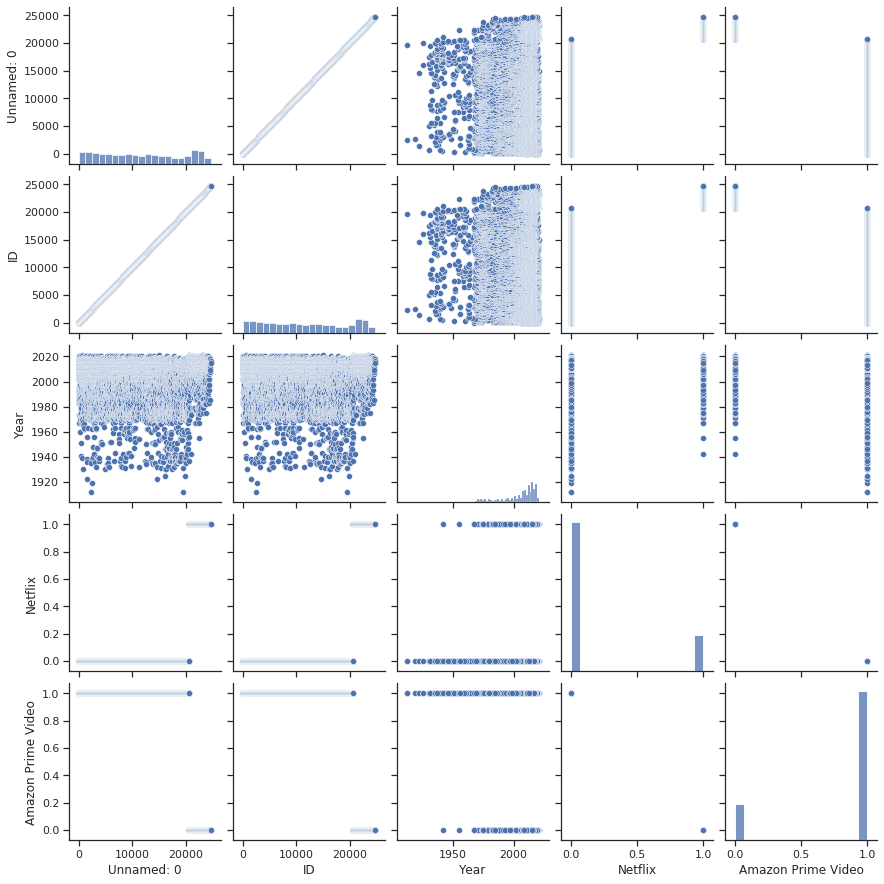

In [12]:
# Парные диаграммы
sns.pairplot(train)

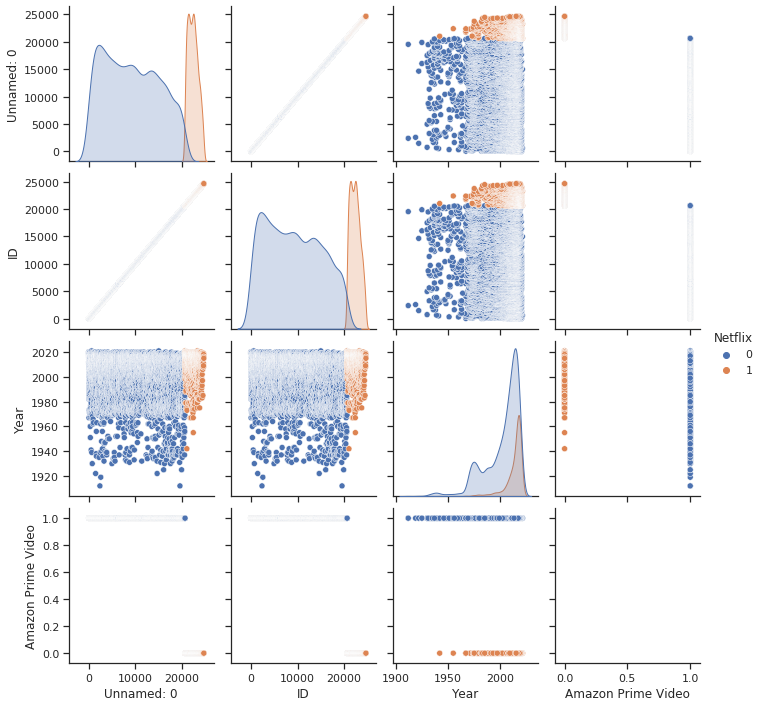

In [13]:
sns.pairplot(train, hue="Netflix")

In [14]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
train['Netflix'].unique()

array([0, 1])

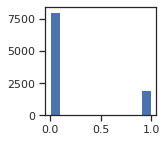

In [15]:
# Оценим дисбаланс классов для Netflix
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(train['Netflix'])
plt.show()

In [16]:
train['Netflix'].value_counts()

0    8036
1    1957
Name: Netflix, dtype: int64

In [17]:
# посчитаем дисбаланс классов
total = train.shape[0]
class_0, class_1 = train['Netflix'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 80.42%, а класс 1 составляет 19.580000000000002%.


Вывод. Дисбаланс классов присутствует, но является приемлемым.

In [18]:
train.columns

Index(['Unnamed: 0', 'ID', 'Title', 'Year', 'Rating', 'IMDb',
       'Rotten Tomatoes', 'Genre', 'Netflix', 'Amazon Prime Video'],
      dtype='object')

In [19]:
# pandas понимает, что в итоге нужен float64
train["IMDb"] = train['IMDb'].astype('float64')
train["Rotten Tomatoes"] = train['Rotten Tomatoes'].astype('float64')
train.dtypes

Unnamed: 0              int64
ID                      int64
Title                  object
Year                    int64
Rating                 object
IMDb                  float64
Rotten Tomatoes       float64
Genre                  object
Netflix                 int64
Amazon Prime Video      int64
dtype: object

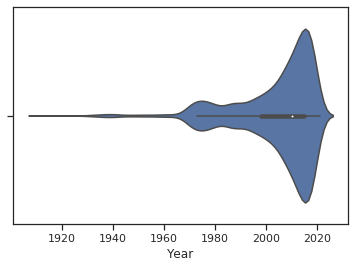

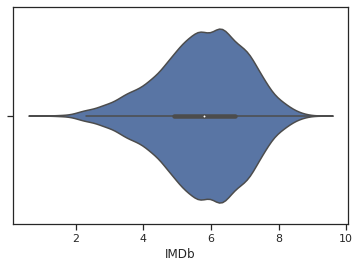

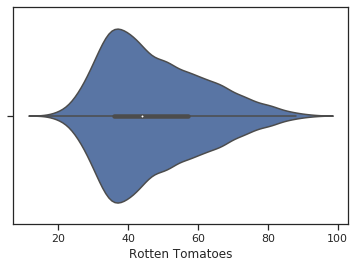

In [21]:
# Скрипичные диаграммы для числовых колонок
for col in ['Year', 'IMDb', 'Rotten Tomatoes']:
    sns.violinplot(x=train[col])
    plt.show()

# Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [31]:
train.dtypes

Unnamed: 0              int64
ID                      int64
Title                  object
Year                    int64
Rating                 object
IMDb                  float64
Rotten Tomatoes       float64
Genre                  object
Netflix                 int64
Amazon Prime Video      int64
dtype: object

In [32]:
# Создадим вспомогательные колонки, 
# чтобы наборы данных можно было разделить.
train['dataset'] = 'TRAIN'

In [33]:
# Колонки для объединения
join_cols = ['Year', 'IMDb', 'Rotten Tomatoes', 
             'Netflix', 'dataset']

In [34]:
data_all = pd.concat([train[join_cols]])

In [36]:
# Проверим корректность объединения
assert data_all.shape[0] == train.shape[0]

In [37]:
data_all.head()

,Year,IMDb,Rotten Tomatoes,Netflix,dataset
0,2019,6.2,81.0,0,TRAIN
1,2019,5.7,74.0,0,TRAIN
2,2019,6.1,72.0,0,TRAIN
3,2019,4.9,50.0,0,TRAIN
4,2019,6.1,79.0,0,TRAIN


In [38]:
# Числовые колонки для масштабирования
scale_cols = ['Year', 'IMDb', 'Rotten Tomatoes']

In [39]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_all[scale_cols])

In [40]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data_all[new_col_name] = sc1_data[:,i]

In [41]:
data_all.head()

,Year,IMDb,Rotten Tomatoes,Netflix,dataset,Year_scaled,IMDb_scaled,Rotten Tomatoes_scaled
0,2019,6.2,81.0,0,TRAIN,0.981651,0.634146,0.833333
1,2019,5.7,74.0,0,TRAIN,0.981651,0.573171,0.743590
2,2019,6.1,72.0,0,TRAIN,0.981651,0.621951,0.717949
3,2019,4.9,50.0,0,TRAIN,0.981651,0.475610,0.435897
4,2019,6.1,79.0,0,TRAIN,0.981651,0.621951,0.807692


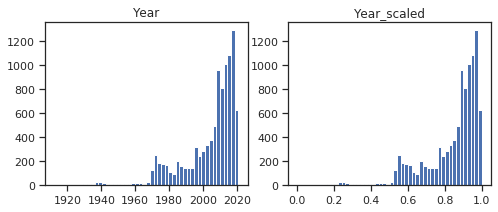

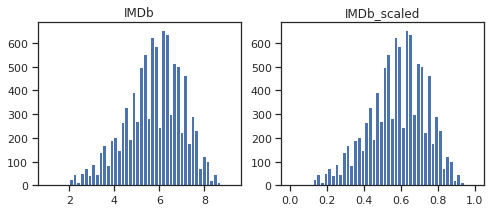

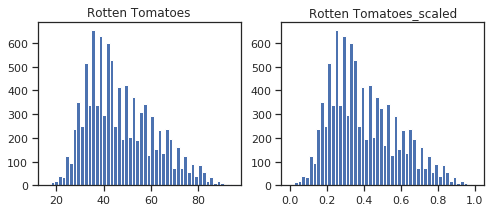

In [42]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data_all[col], 50)
    ax[1].hist(data_all[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

# Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [43]:
# Воспользуемся наличием тестовых выборок, 
# включив их в корреляционную матрицу
corr_cols_1 = scale_cols + ['Netflix']
corr_cols_1

['Year', 'IMDb', 'Rotten Tomatoes', 'Netflix']

In [44]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Netflix']
corr_cols_2

['Year_scaled', 'IMDb_scaled', 'Rotten Tomatoes_scaled', 'Netflix']

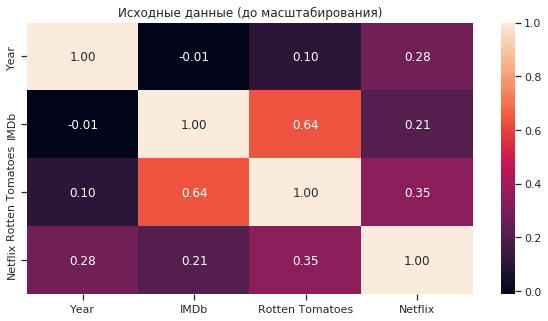

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

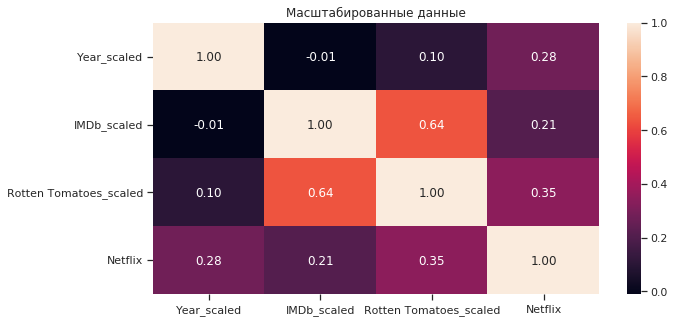

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()



На основе корреляционной матрицы можно сделать следующие выводы:

* Корреляционные матрицы для исходных и масштабированных данных совпадают.
* Целевой признак классификации "Netflix" наиболее сильно коррелирует с Year (0.28), IMBd (0.21) и Rotten Tomatoes (0.35). Эти признаки обязательно следует оставить в модели классификации.
* Целевой признак классификации "Year" наиболее сильно коррелирует с Netflix (0.28), IMBd (-0.01) и Rotten Tomatoes (0.10). Эти признаки обязательно следует оставить в модели классификации.
* Целевой признак классификации "IMBd" наиболее сильно коррелирует с Year (-0.01), Netflix (0.21) и Rotten Tomatoes (0.64). Эти признаки обязательно следует оставить в модели классификации.
* Целевой признак классификации "Rotten Tomatoes" наиболее сильно коррелирует с Year (0.10), IMBd (0.64) и Netflix (0.35). Эти признаки обязательно следует оставить в модели классификации.
* Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.



# Выбор метрик для последующей оценки качества моделей.

В качестве метрик для решения задачи классификации будем использовать:

Метрики, формируемые на основе матрицы ошибок:
Метрика precision:

precision=TPTP+FP

Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция precision_score.
Метрика recall (полнота):

recall=TPTP+FN

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция recall_score.
Метрика F1
-мера

Для того, чтобы объединить precision и recall в единую метрику используется Fβ

-мера, которая вычисляется как среднее гармоническое от precision и recall:

Fβ=(1+β2)⋅precision⋅recallprecision+recall

где β

определяет вес точности в метрике.

На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при β=1

:

F1=2⋅precision⋅recallprecision+recall

Для вычисления используется функция f1_score.
Метрика ROC AUC

Основана на вычислении следующих характеристик:

TPR=TPTP+FN

- True Positive Rate, откладывается по оси ординат. Совпадает с recall.

FPR=FPFP+TN

- False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция roc_auc_score.
В качестве метрик для решения задачи регрессии будем использовать:
Mean absolute error - средняя абсолютная ошибка

MAE(y,y^)=1N⋅∑i=1N|yi−yi^|

где:

    y

- истинное значение целевого признака
y^
- предсказанное значение целевого признака
N

    - размер тестовой выборки

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции mean_absolute_error.
Mean squared error - средняя квадратичная ошибка

MSE(y,y^)=1N⋅∑i=1N(yi−yi^)2

где:

    y

- истинное значение целевого признака
y^
- предсказанное значение целевого признака
N

    - размер тестовой выборки

Вычисляется с помощью функции mean_squared_error.
Метрика R2
или коэффициент детерминации

R2(y,y^)=1−∑i=1N(yi−yi^)2∑i=1N(yi−yi¯¯¯¯¯)2

где:

    y

- истинное значение целевого признака
y^
- предсказанное значение целевого признака
N
- размер тестовой выборки
yi¯¯¯¯=1N⋅∑i=1Nyi

Вычисляется с помощью функции r2_score.

## Сохранение и визуализация метрик

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [47]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()  

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для задачи классификации будем использовать следующие модели:

    Логистическая регрессия
    Метод ближайших соседей
    Машина опорных векторов
    Решающее дерево
    Случайный лес
    Градиентный бустинг

Для задачи регрессии будем использовать следующие модели:

    Линейная регрессия
    Метод ближайших соседей
    Машина опорных векторов
    Решающее дерево
    Случайный лес
    Градиентный бустинг

## Формирование обучающей выборки на основе исходного набора данных.

In [55]:
# На основе масштабированных данных выделим 
# обучающую и тестовую выборки с помощью фильтра
train_data_all = data_all[data_all['dataset']=='TRAIN']
train_data_all.shape

(9993, 8)

In [56]:
# Признаки для задачи классификации
task_clas_cols = ['Year_scaled', 'IMDb_scaled', 'Rotten Tomatoes_scaled']

In [74]:
# Выборки для задачи классификации
clas_X_train = train_data_all[task_clas_cols]
clas_X_test = train_data_all[task_clas_cols]
clas_Y_train = train_data_all['Netflix']
clas_Y_test = train_data_all['Netflix']
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((9993, 3), (9993, 3), (9993,), (9993,))

In [75]:
# Признаки для задачи регресии
task_regr_cols = ['Netflix', 'IMDb_scaled', 'Rotten Tomatoes_scaled']

In [87]:
regr_X_train = train_data_all[task_regr_cols]
regr_X_test = train_data_all[task_regr_cols]
regr_Y_train = train_data_all['Year_scaled']
regr_Y_test = train_data_all['Year_scaled']
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape



((9993, 3), (9993, 3), (9993,), (9993,))

# Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

## Решение задачи классификации

In [88]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(probability=True),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [89]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [90]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [91]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    # Предсказание значений
    Y_pred = model.predict(clas_X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(clas_X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred_proba)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(clas_Y_test.values, Y_pred_proba, ax[0])
    plot_confusion_matrix(model, clas_X_test, clas_Y_test.values, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


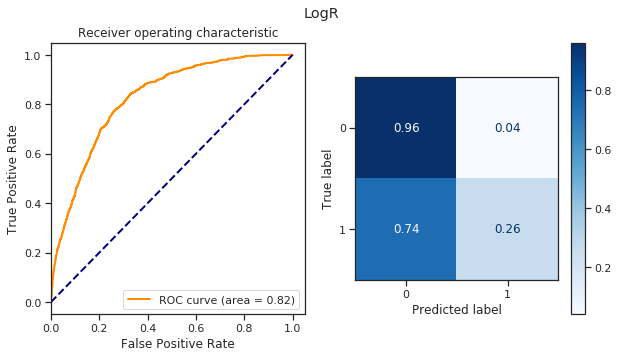

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


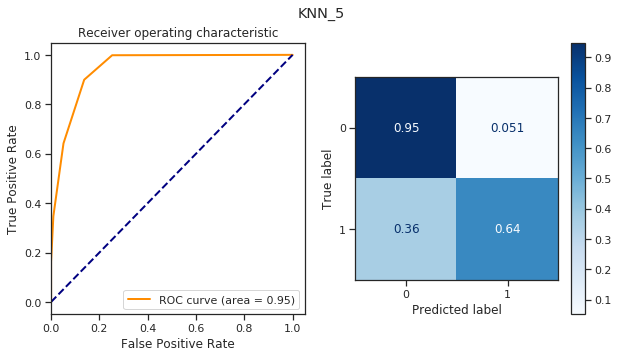

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


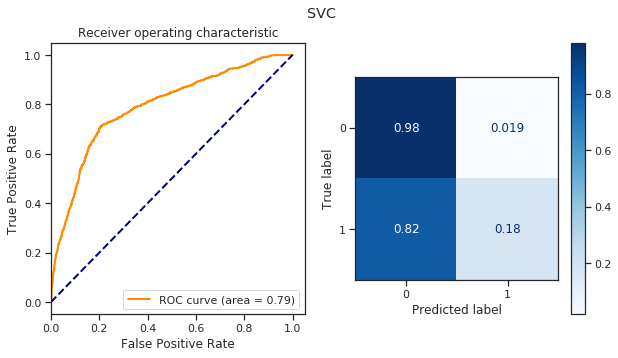

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


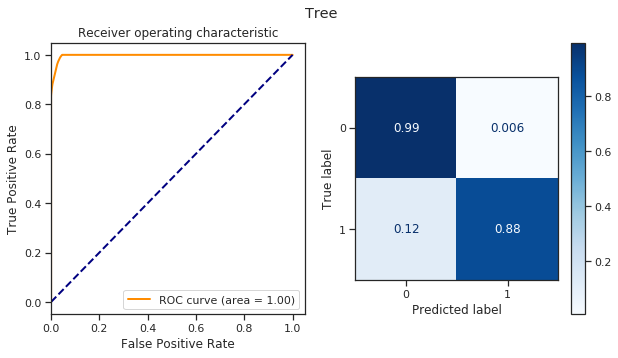

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


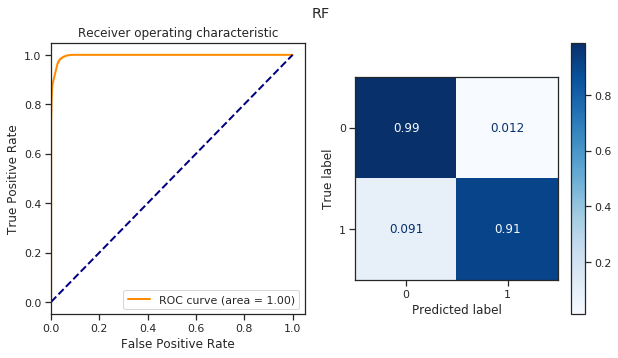

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


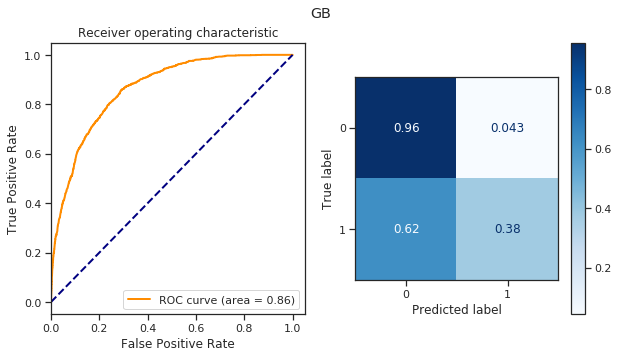

In [92]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Решение задачи регрессии

In [93]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [94]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [95]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('{} \t MAE={}, MSE={}, R2={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(r2, 3)))

In [96]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=0.108, MSE=0.02, R2=0.087
KNN_5 	 MAE=0.083, MSE=0.014, R2=0.351
SVR 	 MAE=0.107, MSE=0.02, R2=0.102
Tree 	 MAE=0.069, MSE=0.012, R2=0.476
RF 	 MAE=0.073, MSE=0.012, R2=0.467
GB 	 MAE=0.102, MSE=0.019, R2=0.164


# Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

## Пример для задачи классификации

In [97]:
clas_X_train.shape

(9993, 3)

In [98]:
n_range_list = list(range(0,1250,50))
n_range_list[0] = 1

In [99]:
n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
          550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
         1100, 1150, 1200])}]

In [100]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(clas_X_train, clas_Y_train)

CPU times: user 32.4 s, sys: 35.2 ms, total: 32.4 s
Wall time: 32.5 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([   1,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200])}],
             scoring='roc_auc')

In [101]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=100)

In [102]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 100}

In [103]:
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])
clf_gs_best_params_txt

'100'

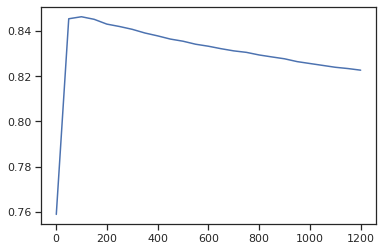

In [104]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

## Пример для задачи регрессии

In [105]:
n_range = np.array(range(1,2000,100))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
         1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901])}]

In [106]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(regr_X_train, regr_Y_train)

CPU times: user 32.7 s, sys: 608 ms, total: 33.3 s
Wall time: 33.4 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901])}],
             scoring='neg_mean_squared_error')

In [107]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(n_neighbors=101)

In [108]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 101}

In [109]:
regr_gs_best_params_txt = str(regr_gs.best_params_['n_neighbors'])
regr_gs_best_params_txt

'101'

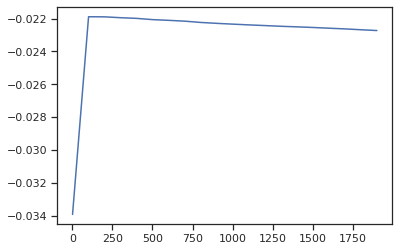

In [110]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

# Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

## Решение задачи классификации

In [113]:
clas_models_grid = {'KNN_5':KNeighborsClassifier(n_neighbors=5), 
                    str('KNN_' + clf_gs_best_params_txt):clf_gs.best_estimator_}

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


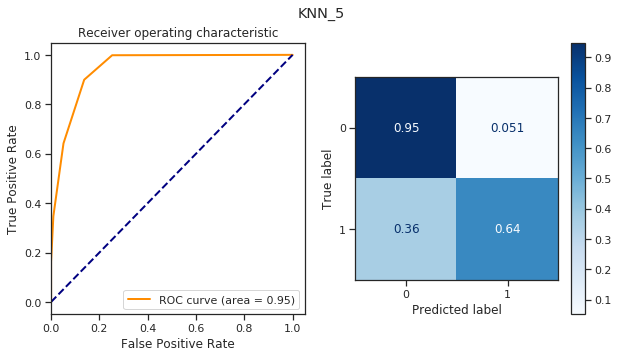

/home/arinafish/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


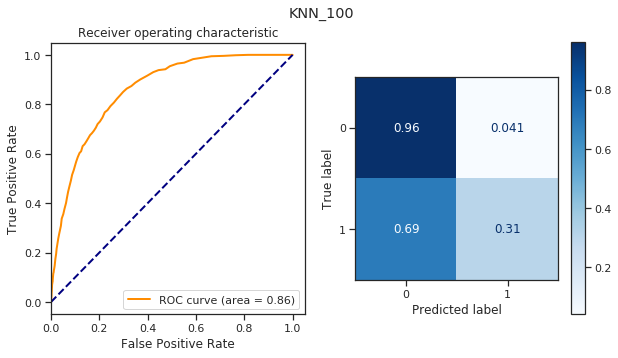

In [114]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

## Решение задачи регрессии

In [115]:
regr_models_grid = {'KNN_5':KNeighborsRegressor(n_neighbors=5), 
                    str('KNN_'+regr_gs_best_params_txt):regr_gs.best_estimator_}


In [116]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN_5 	 MAE=0.083, MSE=0.014, R2=0.351
KNN_101 	 MAE=0.104, MSE=0.019, R2=0.152


# Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

## Решение задачи классификации

In [117]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

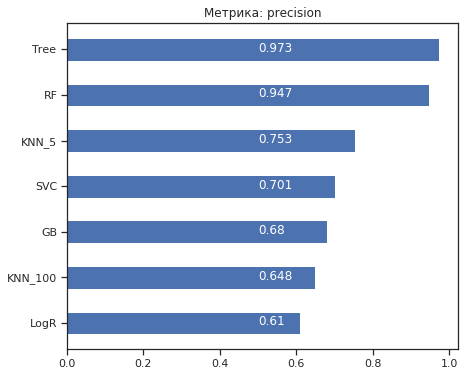

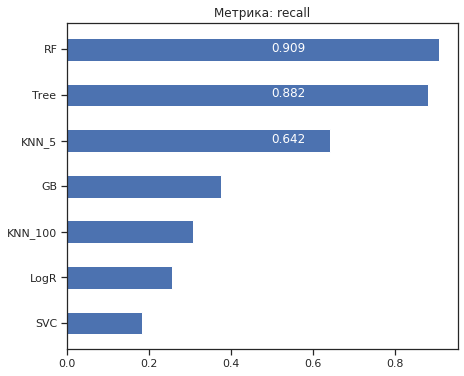

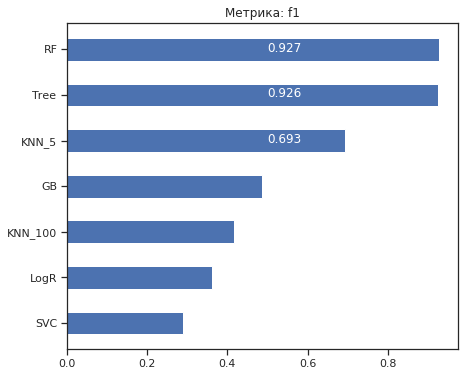

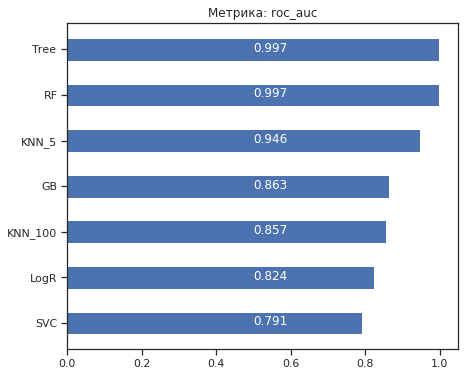

In [118]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

Вывод: на основании четырех используемых метрик лучшими оказались модели Tree и RF.

## Решение задачи регрессии

In [119]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

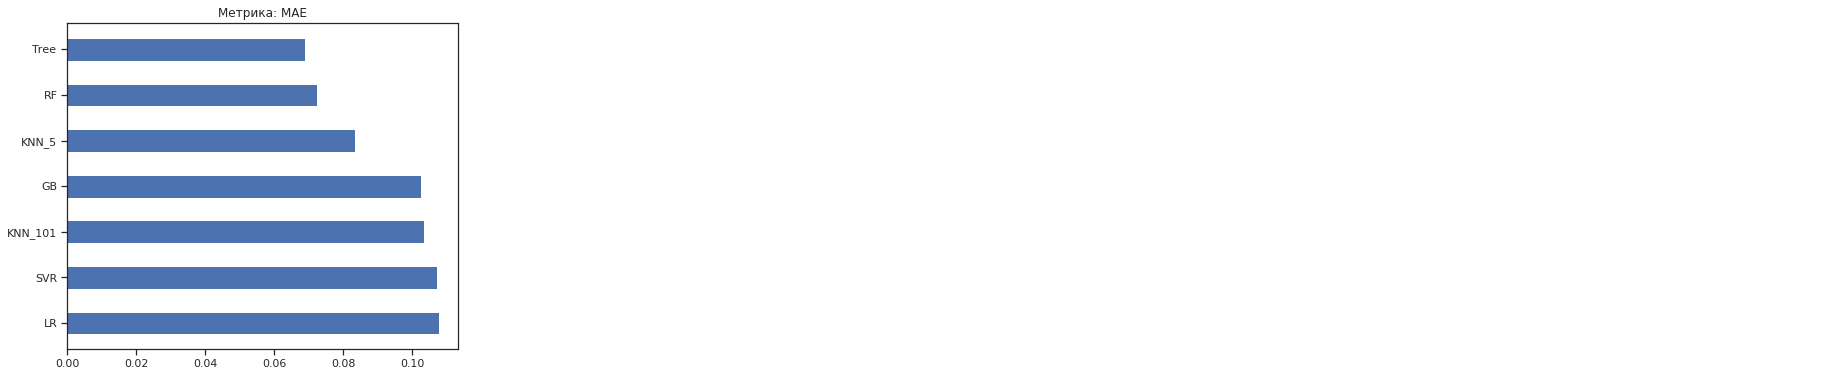

In [122]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

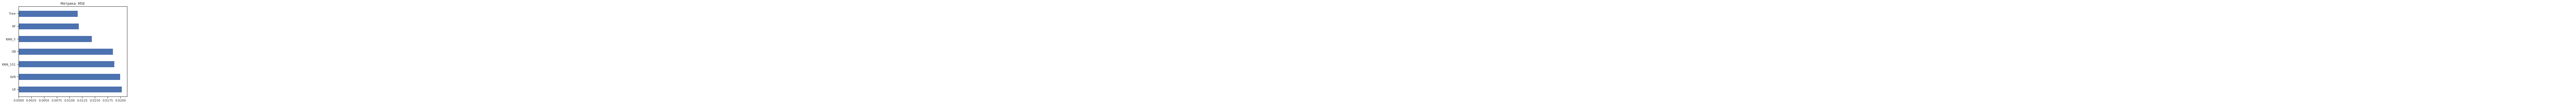

In [125]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

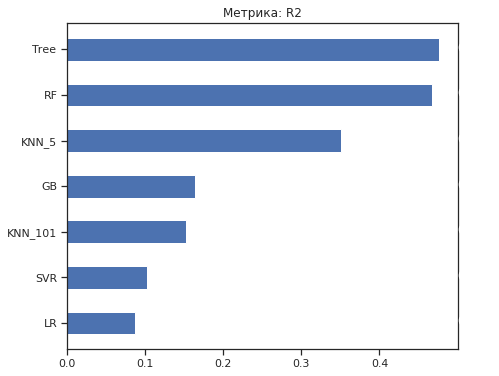

In [124]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

Вывод: лучшей оказалась модель на основе решающего дерева